# RED WINE PORTUGAL

## Inicio da Sessão em PySpark

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz

!tar xf spark-2.4.4-bin-hadoop2.7.tgz

In [ ]:
!pip install -q findspark
!pip install -q pyspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"


In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()


## Importar as Bibliotecas necessárias

In [ ]:
from pyspark import SparkFiles

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

from pyspark.sql import functions as F

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix 

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

##1. Análise do Dataset

## 1.1. Ler e armazenar os dados numa dataframe

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
spark.sparkContext.addFile(url)

dataset = spark.read.csv("file://"+ SparkFiles.get("winequality-red.csv"),header=True, sep=";", inferSchema=True)

dataset.show(10)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|
|         11.2|            0.28|       0.56|           1.9|    0.075|               17.0|           

In [ ]:
dataset.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



## 1.2. Verificar tamanho da dataframe

In [ ]:
data = dataset.toPandas()

TQuality =data.groupby('quality')
pd.DataFrame({'Total':TQuality.size()})

dataset.toPandas().shape

(1599, 12)

## 1.3. Verificar se existem valores omissos

In [ ]:
dataset.toPandas().isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

## 1.4. Identificação dos tipos de dados: se são numéricas (dentro destas, discretas ou contínuas) ou categóricas (dentro destas, nominais ou ordinais)

In [ ]:
dataset.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int32
dtypes: float64(11), int32(1)
memory usage: 143.8 KB


##1.5. Para variáveis numéricas, fazer análise:

### a. Mínimo, máximo, média, mediana, ...

In [ ]:
dataset.toPandas().describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [ ]:
df = dataset.toPandas()
dff = df.drop(['quality'], axis = 1)
dft = df['quality']

### b. Distribuição dos dados

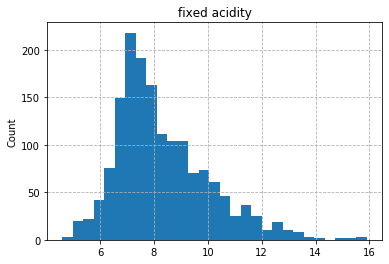

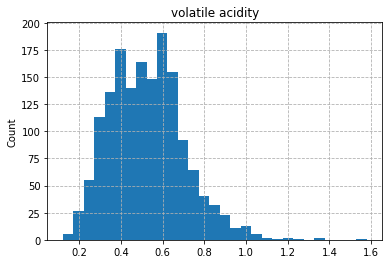

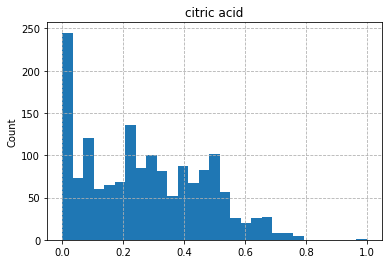

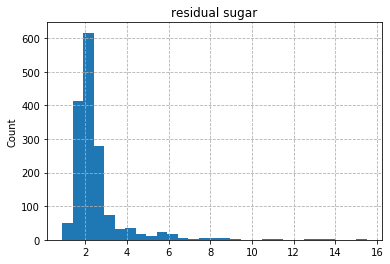

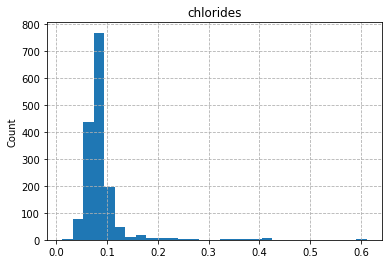

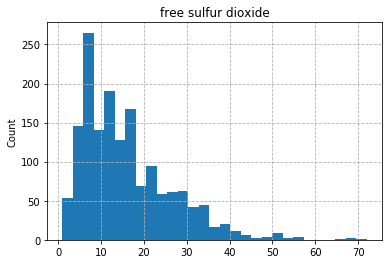

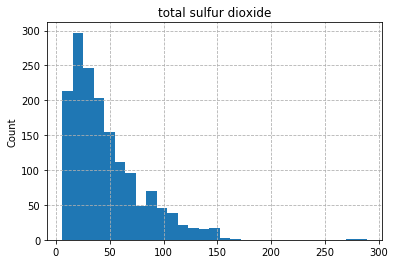

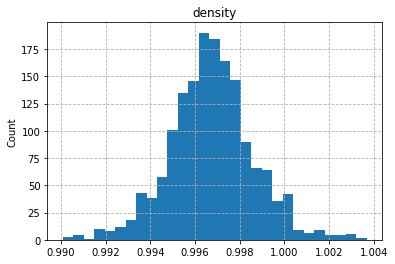

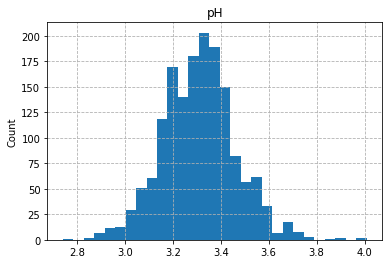

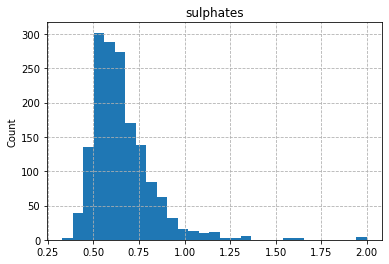

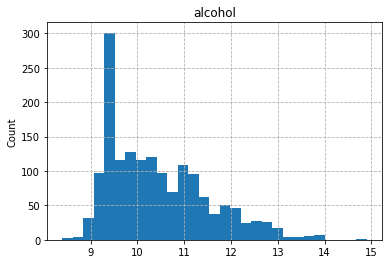

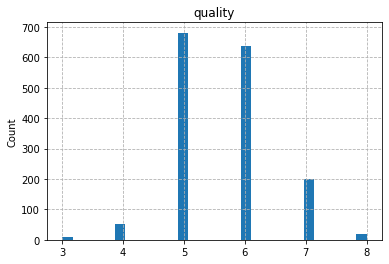

In [ ]:
for i in df:
    plt.hist(df[i],bins=29)
    plt.ylabel('Count')
    plt.title(i)
    plt.grid(linestyle = '--')
    plt.show()

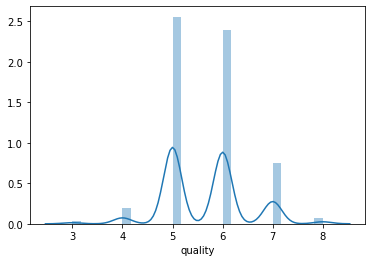

In [ ]:
ax = sns.distplot(df['quality'])

### c. Identificação de outliers

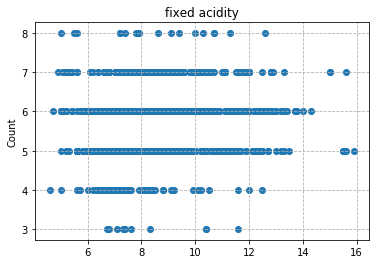

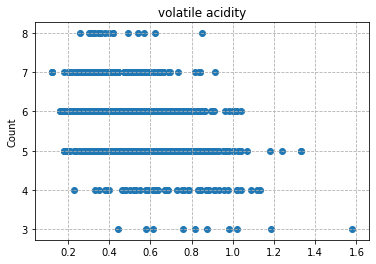

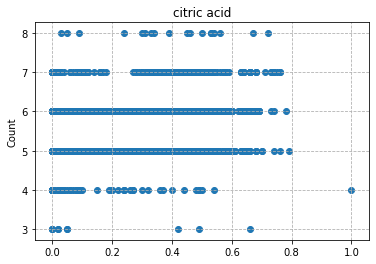

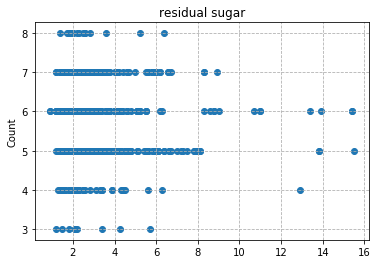

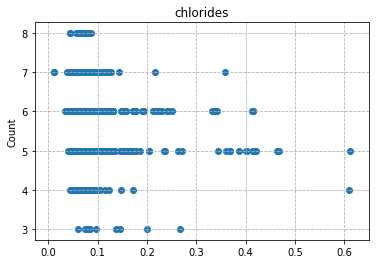

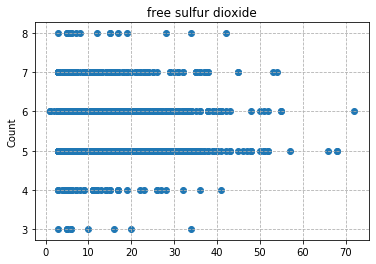

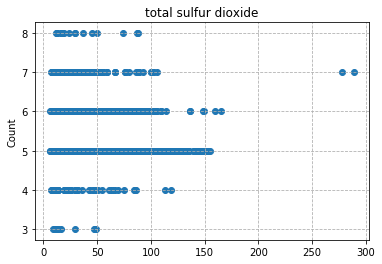

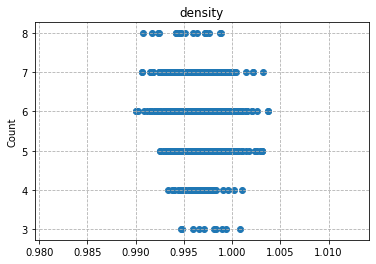

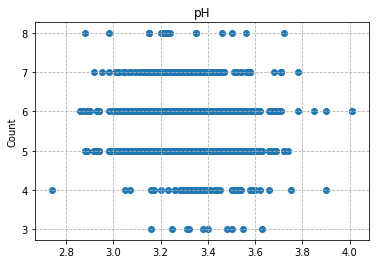

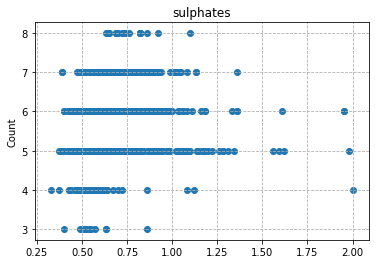

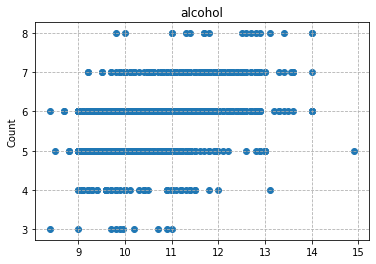

In [ ]:
for i in dff:
    plt.scatter(df[i], dft)
    plt.ylabel('Count')
    plt.title(i)
    plt.grid(linestyle = '--')
    plt.show()

### d. Boxplots

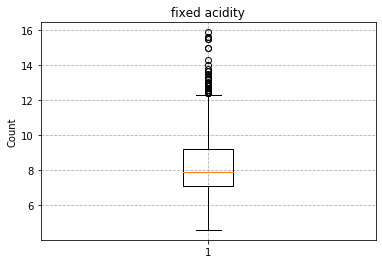

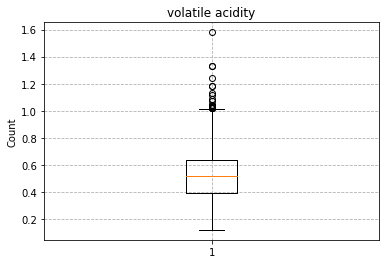

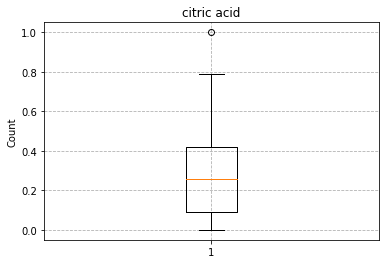

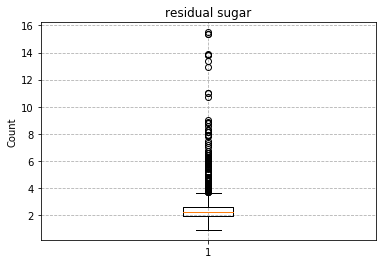

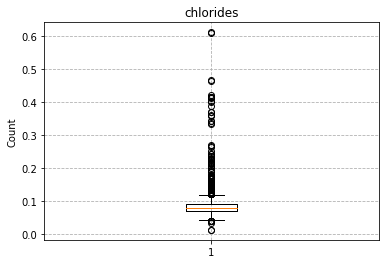

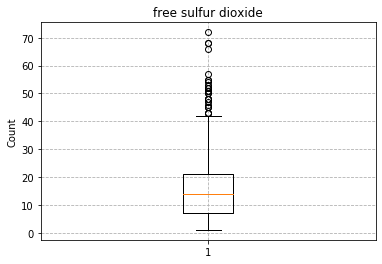

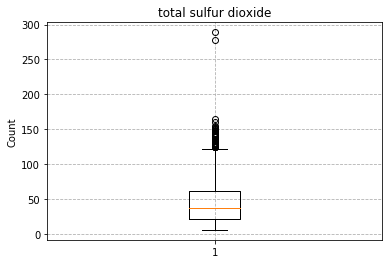

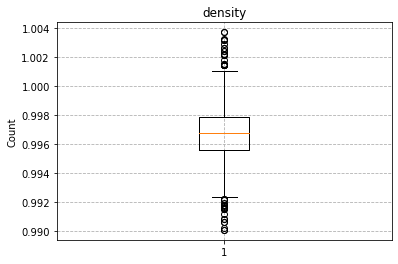

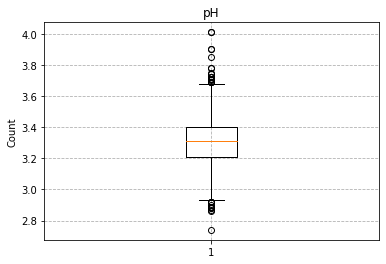

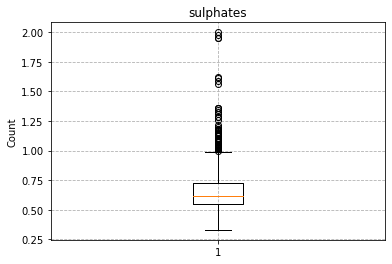

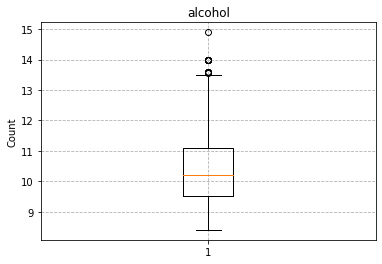

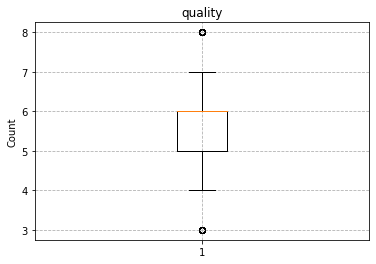

In [ ]:
for i in df:
    plt.boxplot(df[i])
    plt.ylabel('Count')
    plt.title(i)
    plt.grid(linestyle = '--')
    plt.show()

## Algoritmos de Machine Learning

### Criação do Vetor Input

In [ ]:
assembler = VectorAssembler(inputCols= ['fixed acidity','volatile acidity', 'citric acid','residual sugar', 'chlorides', 
                                        'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'], outputCol="features")
output = assembler.transform(dataset)
output = output.withColumn('Default Target', output.quality)
output.show(5)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+--------------------+--------------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|            features|Default Target|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+--------------------+--------------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|[7.4,0.7,0.0,1.9,...|             5|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|[7.8,0.88,0.0,2.6...|             5|
|          7.8|            0.76|       0.04|           2.3|    0.092| 

### Normalização das features

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

scalerModel = scaler.fit(output).transform(output)

scalerModel.select("features","scaledFeatures").show(5)

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[7.4,0.7,0.0,1.9,...|[4.25019565141442...|
|[7.8,0.88,0.0,2.6...|[4.47993595689628...|
|[7.8,0.76,0.04,2....|[4.47993595689628...|
|[11.2,0.28,0.56,1...|[6.43272855349210...|
|[7.4,0.7,0.0,1.9,...|[4.25019565141442...|
+--------------------+--------------------+
only showing top 5 rows



### Transformação do Target para Binário

In [ ]:
from pyspark.sql import functions as F

scalerModel = scalerModel.withColumn("quality", F.when(F.col("quality")<6,0).otherwise(F.when(F.col("quality")>5,1)))

In [ ]:
scalerModel = scalerModel.withColumn("Binary Target", scalerModel.quality)

scalerModel.select("Default Target", "Binary Target").show(5)

+--------------+-------------+
|Default Target|Binary Target|
+--------------+-------------+
|             5|            0|
|             5|            0|
|             5|            0|
|             6|            1|
|             5|            0|
+--------------+-------------+
only showing top 5 rows



### Criação de um Dataframe para treino/teste

In [ ]:
finalized_data = scalerModel.select("scaledFeatures","quality")

finalized_data.show(5)

+--------------------+-------+
|      scaledFeatures|quality|
+--------------------+-------+
|[4.25019565141442...|      0|
|[4.47993595689628...|      0|
|[4.47993595689628...|      0|
|[6.43272855349210...|      1|
|[4.25019565141442...|      0|
+--------------------+-------+
only showing top 5 rows



### Train/Test Split

In [ ]:
train, test = finalized_data.randomSplit([0.8, 0.2],seed=1000)
print("training dataset:", str(train.count()))
print("test dataset:", str(test.count()))

training dataset: 1302
test dataset: 297


## Algoritmo de Regressão Logística

In [ ]:
lr = LogisticRegression(featuresCol = 'scaledFeatures',labelCol="quality")

lrModel = lr.fit(train)

In [ ]:
predict_train=lrModel.transform(train)
predict_test=lrModel.transform(test)

predict_test.show(10)

+--------------------+-------+--------------------+--------------------+----------+
|      scaledFeatures|quality|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|[2.81431874215279...|      1|[-4.0077188368876...|[0.01785038045357...|       1.0|
|[2.87175381852326...|      1|[-3.8614642406216...|[0.02060372924972...|       1.0|
|[2.87175381852326...|      0|[0.85598250891366...|[0.70182060248906...|       0.0|
|[2.92918889489372...|      1|[-2.3872275746371...|[0.08415185741717...|       1.0|
|[2.98662397126419...|      1|[-4.2601398896331...|[0.01392371951227...|       1.0|
|[2.98662397126419...|      1|[-1.0259837249615...|[0.26386348340226...|       1.0|
|[3.04405904763465...|      1|[-3.1935552902625...|[0.03940897021365...|       1.0|
|[3.10149412400512...|      1|[-0.1036747355410...|[0.47410450666366...|       1.0|
|[3.10149412400512...|      1|[-0.5479192674755...|[0.36634728943622...|    

### Valores de accuracy de treino e teste

In [ ]:
evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="quality")

predict_test.select("quality","rawPrediction","prediction","probability").show(5)

print("Train score {}".format(evaluator.evaluate(predict_train)))
print("Test score {}".format(evaluator.evaluate(predict_test)))

+-------+--------------------+----------+--------------------+
|quality|       rawPrediction|prediction|         probability|
+-------+--------------------+----------+--------------------+
|      1|[-4.0077188368876...|       1.0|[0.01785038045357...|
|      1|[-3.8614642406216...|       1.0|[0.02060372924972...|
|      0|[0.85598250891366...|       0.0|[0.70182060248906...|
|      1|[-2.3872275746371...|       1.0|[0.08415185741717...|
|      1|[-4.2601398896331...|       1.0|[0.01392371951227...|
+-------+--------------------+----------+--------------------+
only showing top 5 rows

Train score 0.8164787264285019
Test score 0.8345847449867233


### Matriz de confusão

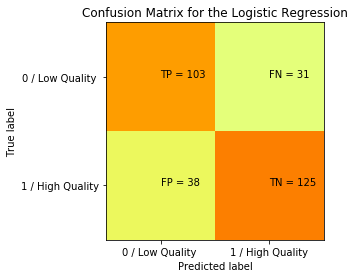

In [ ]:
cmRL = confusion_matrix(test.select("quality").toPandas(), predict_test.select("prediction").toPandas())

fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(4, 4))

plt.clf()
plt.imshow(cmRL, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0 / Low Quality ','1 / High Quality']
plt.title('Confusion Matrix for the Logistic Regression')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=0)
plt.yticks(tick_marks, classNames)
s = [['TP','FN'], ['FP', 'TN']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cmRL[i][j]))
plt.show()

### Valores de precisão

In [ ]:
print(classification_report(test.select("quality").toPandas(), predict_test.select("prediction").toPandas()))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75       134
           1       0.80      0.77      0.78       163

    accuracy                           0.77       297
   macro avg       0.77      0.77      0.77       297
weighted avg       0.77      0.77      0.77       297



### K-Fold Cross Validation

In [ ]:
paramGrid = ParamGridBuilder()\
    .addGrid(lr.fitIntercept,[False, True])\
    .addGrid(lr.regParam,[0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="quality"),
                          numFolds=5)  

In [ ]:
cvModel = crossval.fit(train)

prediction = cvModel.transform(test)

print("K-Fold Cross Validation Score: {}".format(evaluator.evaluate(prediction)))

K-Fold Cross Validation Score: 0.8337606446296127


### Gráficos de Regressão Logística

In [ ]:
scalerModel.columns
dataframePD = scalerModel.select('fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality').toPandas()

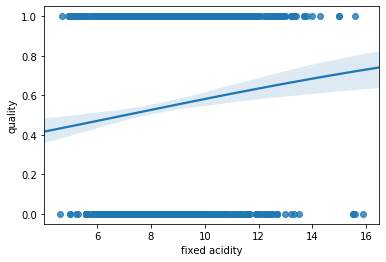

In [ ]:
sns.regplot(x=dataframePD['fixed acidity'], y=dataframePD['quality'],  logistic=True, ci=95)

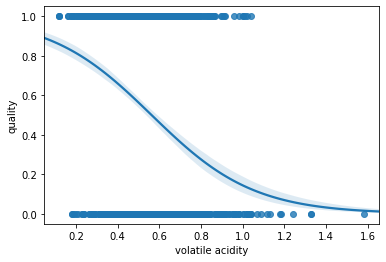

In [ ]:

sns.regplot(x=dataframePD['volatile acidity'], y=dataframePD['quality'],  logistic=True, ci=95)

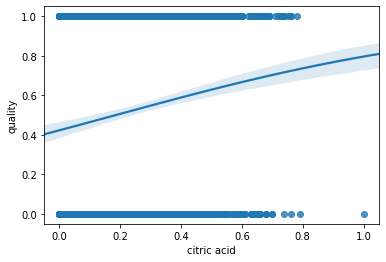

In [ ]:
sns.regplot(x=dataframePD['citric acid'], y=dataframePD['quality'],  logistic=True, ci=95)

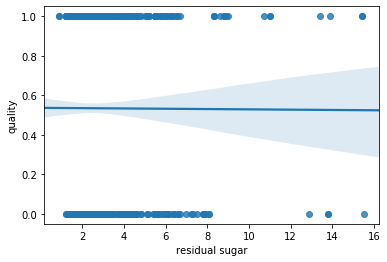

In [ ]:
sns.regplot(x=dataframePD['residual sugar'], y=dataframePD['quality'],  logistic=True, ci=95)

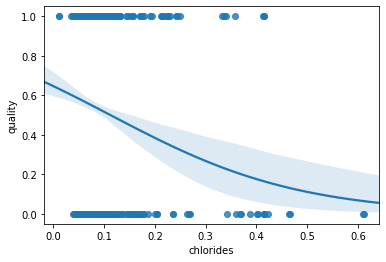

In [ ]:
sns.regplot(x=dataframePD['chlorides'], y=dataframePD['quality'],  logistic=True, ci=95)

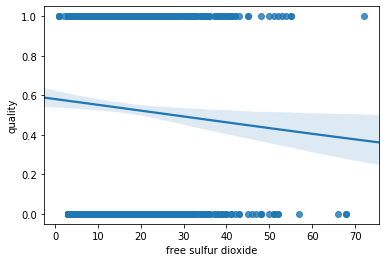

In [ ]:
sns.regplot(x=dataframePD['free sulfur dioxide'], y=dataframePD['quality'],  logistic=True, ci=95)

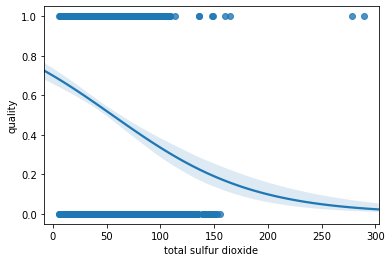

In [ ]:
sns.regplot(x=dataframePD['total sulfur dioxide'], y=dataframePD['quality'],  logistic=True, ci=95)

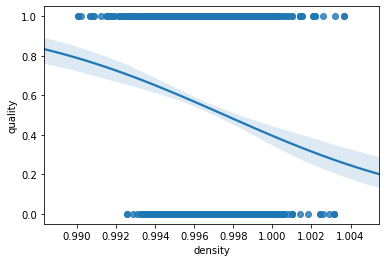

In [ ]:
sns.regplot(x=dataframePD['density'], y=dataframePD['quality'],  logistic=True, ci=95)

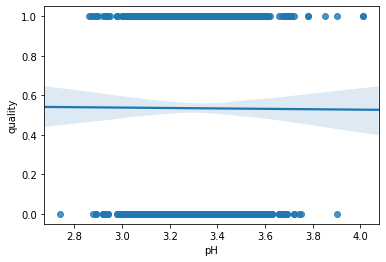

In [ ]:
sns.regplot(x=dataframePD['pH'], y=dataframePD['quality'],  logistic=True, ci=95)

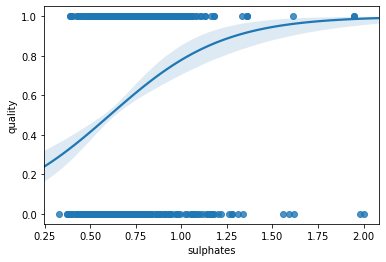

In [ ]:
sns.regplot(x=dataframePD['sulphates'], y=dataframePD['quality'],  logistic=True, ci=95)

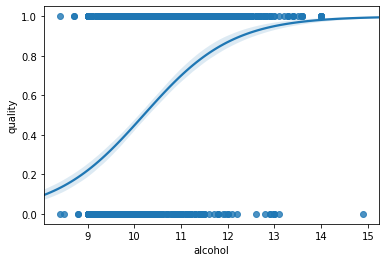

In [ ]:
sns.regplot(x=dataframePD['alcohol'], y=dataframePD['quality'],  logistic=True, ci=95)

## Algortimo de Random Forest

### Descobrir o melhor número de árvores

In [ ]:
trees = list(range(1,30))
tt_scores = []
for k in range(1,30):
    rf = RandomForestClassifier(featuresCol="scaledFeatures", labelCol='quality',numTrees=k, seed=2)
    rfModel = rf.fit(train)
    predictRF_train=rfModel.transform(train)
    predictRF_test=rfModel.transform(test)
    evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="quality")
    a = evaluator.evaluate(predictRF_train)
    b =evaluator.evaluate(predictRF_test)
    
    var = a -b 

    tt_scores.append(var)

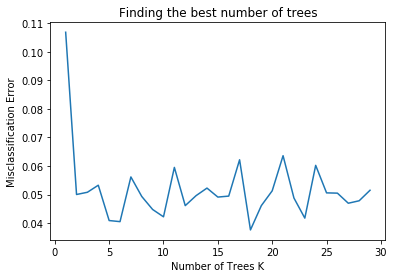

O melhor numero de trees é 18


In [ ]:
ME = [x for x in tt_scores]


plt.plot(trees, ME)
plt.title('Finding the best number of trees')
plt.xlabel('Number of Trees K')
plt.ylabel('Misclassification Error')
plt.show()


optimal_k = trees[ME.index(min(ME))]
print("O melhor numero de trees é {}".format(optimal_k))

### Algoritmo de RF com o melhor número de árvores


In [ ]:
rf = RandomForestClassifier(featuresCol="scaledFeatures", labelCol='quality',numTrees=18,seed=2)

rfModel = rf.fit(train)

predictRF_train=rfModel.transform(train)
predictRF_test=rfModel.transform(test)

### Valores de accuracy de treino e teste

In [ ]:
evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="quality")


print("Train Score: {}".format(evaluator.evaluate(predictRF_train)))
print("Test Score: {}".format(evaluator.evaluate(predictRF_test)))

Train Score: 0.8975859945039312
Test Score: 0.8599487226444467


### Matriz de Confusão

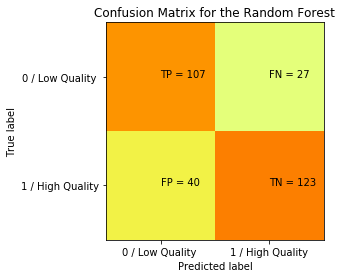

In [ ]:
cmRF = confusion_matrix(test.select("quality").toPandas(), predictRF_test.select("prediction").toPandas())

fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(4, 4))

plt.clf()
plt.imshow(cmRF, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0 / Low Quality ','1 / High Quality']
plt.title('Confusion Matrix for the Random Forest')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=0)
plt.yticks(tick_marks, classNames)
s = [['TP','FN'], ['FP', 'TN']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cmRF[i][j]))
plt.show()

### Valores de precisão

In [ ]:
print(classification_report(test.select("quality").toPandas(), predictRF_test.select("prediction").toPandas()))

              precision    recall  f1-score   support

           0       0.73      0.80      0.76       134
           1       0.82      0.75      0.79       163

    accuracy                           0.77       297
   macro avg       0.77      0.78      0.77       297
weighted avg       0.78      0.77      0.77       297



### K-Fold Cross Validation

In [ ]:

rfparamGrid = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [2, 5, 10])
               .addGrid(rf.maxBins, [5, 10, 20])
               .addGrid(rf.numTrees, [5, 20, 50])
             .build())

rfcrossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=rfparamGrid,
                          evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="quality"),
                          numFolds=5)  

In [ ]:
rfcvModel = rfcrossval.fit(train)

predictionR = rfcvModel.transform(test)

print("K-Fold Cross Validation Score: {}".format(evaluator.evaluate(predictionR)))

K-Fold Cross Validation Score: 0.8636113908982705
